In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler,Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_validate,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, chi2, SelectFromModel,mutual_info_classif
from sklearn.feature_selection import VarianceThreshold, RFE
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('Datasets\winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
x=df[[x for x in df.columns if x !='quality']]
y=df[['quality']]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=1)

In [4]:
train=x_train.join(y_train)
test=x_test.join(y_test)

In [5]:
# Checking null counts in train and test data

train_null_counts=pd.DataFrame(train.isnull().sum(),columns=['train_null_count'])
train_null_counts=train_null_counts.loc[train_null_counts.train_null_count>0]
test_null_counts=pd.DataFrame(test.isnull().sum(),columns=['test_null_count'])
test_null_counts=test_null_counts.loc[test_null_counts.test_null_count>0]
null_counts=test_null_counts.join(train_null_counts).fillna(0)
null_counts['train_null_%']=round((null_counts['train_null_count']/train.shape[0])*100,2)
null_counts['test_null_%']=round((null_counts['test_null_count']/test.shape[0])*100,2)
null_counts

,test_null_count,train_null_count,train_null_%,test_null_%


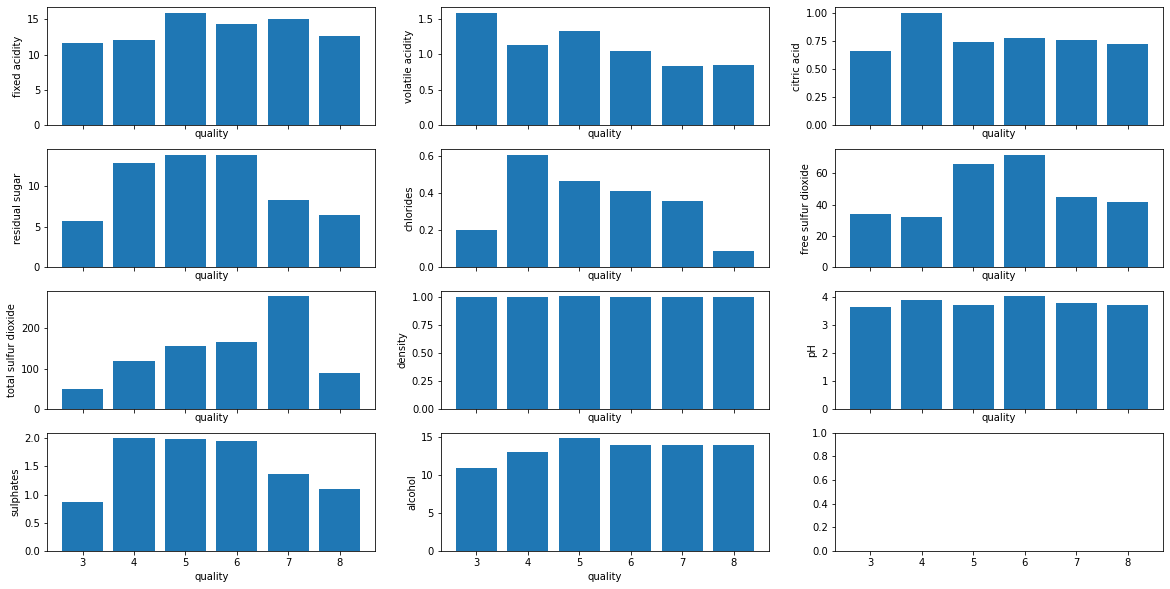

In [6]:
fig,ax=plt.subplots(figsize=(20,10),nrows=4,ncols=3,sharex=True)
for i,j in zip(ax.flat,[x for x in train.columns if x!='quality']):
    i.bar(x=train.quality,height=train[j])
    i.set_ylabel(j)
    i.set_xlabel('quality')

In [7]:
corr=train.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.239649,0.676493,0.106776,0.109928,-0.142040,-0.101036,0.682882,-0.691571,0.207100,-0.074409,0.120297
volatile acidity,-0.239649,1.000000,-0.543267,-0.007611,0.056242,-0.011436,0.081553,0.037981,0.233141,-0.264996,-0.214119,-0.406165
citric acid,0.676493,-0.543267,1.000000,0.172642,0.229181,-0.054859,0.032081,0.370332,-0.567533,0.336683,0.108525,0.222398
residual sugar,0.106776,-0.007611,0.172642,1.000000,0.044665,0.153871,0.195358,0.325476,-0.083149,0.011566,0.065158,0.011341
chlorides,0.109928,0.056242,0.229181,0.044665,1.000000,-0.004968,0.035511,0.203501,-0.280919,0.379276,-0.228044,-0.133501
free sulfur dioxide,-0.142040,-0.011436,-0.054859,0.153871,-0.004968,1.000000,0.675426,-0.033803,0.056191,0.058513,-0.064582,-0.041181
total sulfur dioxide,-0.101036,0.081553,0.032081,0.195358,0.035511,0.675426,1.000000,0.071286,-0.062917,0.041538,-0.195758,-0.192083
density,0.682882,0.037981,0.370332,0.325476,0.203501,-0.033803,0.071286,1.000000,-0.357538,0.159858,-0.502655,-0.190350
pH,-0.691571,0.233141,-0.567533,-0.083149,-0.280919,0.056191,-0.062917,-0.357538,1.000000,-0.217236,0.208165,-0.060894
sulphates,0.207100,-0.264996,0.336683,0.011566,0.379276,0.058513,0.041538,0.159858,-0.217236,1.000000,0.083408,0.242895


<AxesSubplot:>

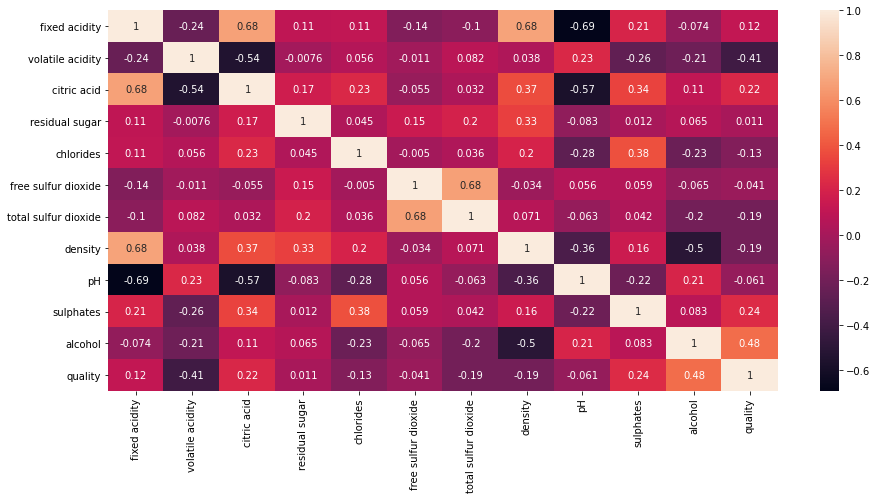

In [8]:
fig=plt.subplots(figsize=(15,7))
sns.heatmap(corr,annot=True)

In [9]:
train.quality.sort_values().unique()

array([3, 4, 5, 6, 7, 8], dtype=int64)

In [10]:
# 1 'good' 0 'bad'
train['quality']=train['quality'].apply(lambda x: 1 if x >5.5 else 0)
test['quality']=test['quality'].apply(lambda x: 1 if x >5.5 else 0)

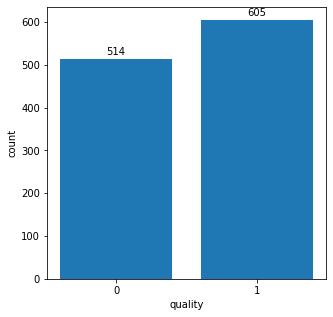

In [11]:
fig,ax=plt.subplots(figsize=(5,5))
ax.bar(x=train.quality.value_counts().index,height=train.quality.value_counts().values)
ax.set_xticks([0,1])
ax.set_xlabel('quality')
ax.set_ylabel('count')
for p in ax.patches:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2
    ax.annotate("%g" % p.get_height(), xy=(x,h), xytext=(0,2),textcoords="offset points", ha="center", va="bottom")

In [12]:
x=train[[x for x in train.columns if x !='quality']]
y=train[['quality']]

xx=test[[x for x in test.columns if x !='quality']]
yy=test[['quality']]

In [13]:
models=[LogisticRegression(random_state=1),LinearDiscriminantAnalysis(),LinearSVC(random_state=1),
        RandomForestClassifier(random_state=1),BaggingClassifier(random_state=1)]
scales=[RobustScaler(),StandardScaler(),Normalizer()]
result=[]
for model in models:
    final=[]
    for scale in scales:
        pipe=Pipeline([('scale',scale),('model',model)])
        score=cross_val_score(estimator=pipe,X=x,y=np.array(y).ravel(),cv=5,n_jobs=-1,scoring='f1').mean()
        final.append(round(score*100,2))
    result.append(final)
pd.DataFrame(result,index=['Logistic Regression','LinearDiscriminantAnalysis','LinearSVC',
                          'RandomForestClassifier','BaggingClassifier'],columns=['Robust Scaler','Standard Scaler','Normalizer'])

,Robust Scaler,Standard Scaler,Normalizer
Logistic Regression,76.34,76.44,69.80
LinearDiscriminantAnalysis,76.50,76.50,75.75
LinearSVC,76.20,76.41,69.24
RandomForestClassifier,80.24,80.27,78.63
BaggingClassifier,77.48,77.27,74.47


In [14]:
pipe=Pipeline([('scale',StandardScaler()),('model',RandomForestClassifier(random_state=1))])
pipe.fit(x,y)
y_pred=pipe.predict(xx)
metrics_df=pd.DataFrame(data=[metrics.f1_score(yy,y_pred),metrics.precision_score(yy,y_pred),
                              metrics.recall_score(yy,y_pred),metrics.accuracy_score(yy,y_pred)],
                        index=['F1 Score','Precision','Recall','Accuracy'],
                        columns=['Score'])
metrics_df

,Score
F1 Score,0.809035
Precision,0.831224
Recall,0.788000
Accuracy,0.806250


Text(0.5, 1.0, 'Confusion Matrix')

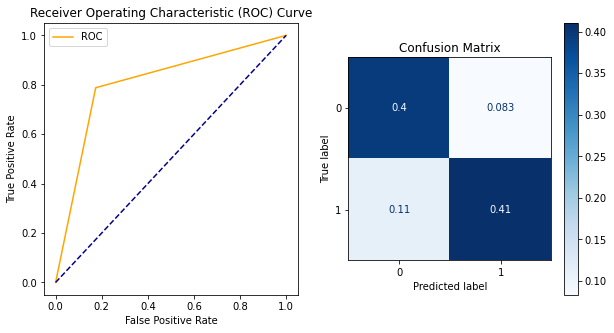

In [15]:
fper, tper, thresholds = metrics.roc_curve(yy, y_pred)
fig,ax=plt.subplots(figsize=(10,5),nrows=1,ncols=2)
ax[0].plot(fper, tper, color='orange', label='ROC')
ax[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[0].legend()
metrics.plot_confusion_matrix(pipe, xx, yy,cmap=plt.cm.Blues, normalize = 'all',ax=ax[1])
ax[1].set_title('Confusion Matrix')